## Yield Spread model

This notebook implements a model to predict new yield spreads from reference and trade history data. The modifications are made from a team member's experiment to reduce cross-over

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-11-02 19:23:35.717805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 19:23:35.728496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 19:23:35.729055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Setting the environment variables

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ahmad_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client and GCP storage client

In [4]:
bq_client = bigquery.Client()
storage_client = storage.Client()

Declaring hyper-parameters

In [5]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0007
BATCH_SIZE = 10000
NUM_EPOCHS = 100

DROPOUT = 0.10
SEQUENCE_LENGTH = 5
NUM_FEATURES = 6

Checking if the treasury spreads and target attention features are present in PREDICTORS 

In [6]:
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

#### Data Preparation
We grab the data from a GCP bucket. The data is prepared using the ficc python package. More insight on how the data is prepared can be found [here](https://github.com/Ficc-ai/ficc/blob/ahmad_ml/ml_models/sequence_predictors/data_prep/data_preparation.ipynb)

In [7]:
%%time
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('automated_training/processed_data_test.pkl') as f:
# with fs.open('ahmad_data/processed_data_dollar_price_2023-09-12-21:27.pkl') as f:
    data = pd.read_pickle(f)

CPU times: user 1min 57s, sys: 28.7 s, total: 2min 25s
Wall time: 4min 32s


#### Date range for data

In [8]:
data.trade_date.max()

Timestamp('2023-11-01 00:00:00')

In [9]:
data.trade_date.min()

Timestamp('2023-01-03 00:00:00')

In [10]:
print(f'Restricting history to {SEQUENCE_LENGTH} trades')
data.trade_history = data.trade_history.apply(lambda x: x[:SEQUENCE_LENGTH])
data.target_attention_features = data.target_attention_features.apply(lambda x:x[:SEQUENCE_LENGTH])

Restricting history to 5 trades


In [11]:
data.trade_history.iloc[0].shape

(5, 6)

In [12]:
data.target_attention_features.iloc[0].shape

(1, 3)

In [13]:
data.sort_values('trade_datetime', inplace=True)

We don't give a predictions if yield is greater than 10

In [14]:
data = data[data['yield'] < 1000]

In [15]:
len(data)

9010896

### Creating features from trade history

This implementation is an adaption of Charles's implementation 

In [16]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] #+ row.trade_type #removing this to reduce crossover
    seconds_ago = trade[5]
    quantity_diff = np.log10(1 + np.abs(10**trade[2] - 10**row.quantity))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [17]:
%%time
YS_COLS = get_trade_history_columns()
temp = data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
data[YS_COLS] = pd.DataFrame(temp.tolist(), index=data.index)

CPU times: user 3min 3s, sys: 26.4 s, total: 3min 30s
Wall time: 5min 44s


Adding trade history features to PREDICTORS list

In [18]:
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)

This feature is used to check if there are any NaN values in the trade history. **It is not used to train the model**. 

In [19]:
%%time
print(len(data))
data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
data = data.dropna(subset=['trade_history_sum'])
print(len(data))

9010896
9010896
CPU times: user 48.7 s, sys: 11.1 s, total: 59.8 s
Wall time: 1min 5s


For the purpose of plotting, not used in training

In [20]:
data.purpose_sub_class.fillna(0, inplace=True)

Creating new ys label

In [21]:
data['new_ys'] = data['yield'] - data['new_ficc_ycl']
data['diff_ys'] = data['new_ys'] - data['last_yield_spread']
# data['new_ys'] = data['yield'] - data['new_real_time_ficc_ycl']

Adding additional features proposed by Charles

In [22]:
data.last_trade_date = pd.to_datetime(data.last_trade_date)

In [23]:
data['last_duration'] = (data.last_calc_date - data.last_trade_date).dt.days

In [24]:
def duration(coupon, ytw, years, dollar_price, peryear=2):
    ytw = ytw.clip(0.001,np.inf)
    c = (coupon/100) / peryear
    y = (ytw/10000) / peryear
    n = years * peryear
    m = peryear
    macaulay_duration = ((1+y) / (m*y)) - ( (1 + y + n*(c-y)) / ((m*c* ((1+y)**n - 1)) + m*y))
    modified_duration = macaulay_duration / (1 + y)
    dv01 = modified_duration * dollar_price / 10000
    return dv01

def add_additional_feature(data):
    data['diff_ficc_ycl'] = data.new_ficc_ycl - data.last_ficc_ycl
    data['diff_ficc_treasury_spread'] = data.last_ficc_ycl - (data.treasury_rate * 100)
    data['dv01'] = duration(data.coupon, data.last_yield, data.last_duration, data.last_dollar_price)
    data['approx_dpd'] =  data.dv01 * data.diff_ficc_ycl
    data['overage'] =  (data.last_dollar_price + data.approx_dpd - data.next_call_price)
    #data['de_minimis_gap'] = data.last_dollar_price - data.de_minimis_threshold
    return data

data = add_additional_feature(data)
additional_features = ['diff_ficc_ycl','diff_ficc_treasury_spread','dv01','approx_dpd','overage']#,'de_minimis_gap']
# for i in additional_features:
#     if i not in NON_CAT_FEATURES:
#         NON_CAT_FEATURES.append(i)
#         PREDICTORS.append(i)

Selecting a subset of features for training. PREDICTORS are the features that we are going to use to train the model. More information about the feature set can be found [here](https://github.com/Ficc-ai/ficc_python/blob/d455bd30eca18f26a2535523530facad516dd90f/ficc/utils/auxiliary_variables.py#L120). We also select a set of additonal features, which are not used in training. These features are used to uderstand the results from the model.

In [25]:
auxiliary_features = ['dollar_price',
                     'calc_date', 
                     'trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'calc_day_cat',
                     'yield',
                     'ficc_ycl',
                     'new_ys',
                     'trade_history_sum',
                     'new_ficc_ycl',
                     'days_to_refund',
                     'last_dollar_price',
                     'last_rtrs_control_number',
                     'is_called',
                     'federal_tax_status','diff_ys']

In [26]:
processed_data = data[IDENTIFIERS + PREDICTORS + auxiliary_features]

Checking for missing data and NaN values

In [27]:
print(len(processed_data))
processed_data.issue_amount = processed_data.issue_amount.replace([np.inf, -np.inf], np.nan)
processed_data.dropna(inplace=True, subset=PREDICTORS)
print(len(processed_data))

9010896
9010896


Here is a list of exclusions that we will be experimenting with. The model is trained with these exclusions.
<ul>
<li>Callable less than a year in the future
<li>Maturity less than a year in the future and more than 30 years in the future
</ul>


In [28]:
len(processed_data)

9010896

In [29]:
# processed_data = processed_data[(processed_data.days_to_call == 0) | (processed_data.days_to_call > np.log10(400))]
# processed_data = processed_data[(processed_data.days_to_refund == 0) | (processed_data.days_to_refund > np.log10(400))]
# processed_data = processed_data[(processed_data.days_to_maturity == 0) | (processed_data.days_to_maturity > np.log10(400))]
# processed_data = processed_data[processed_data.days_to_maturity < np.log10(30000)]

In [30]:
len(processed_data)

9010896

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [31]:
categorical_feature_values = {'purpose_class' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                                 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
                                                 47, 48, 49, 50, 51, 52, 53],
                              'rating' : ['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB', 'BB+', 'BB-',
                                         'BBB', 'BBB+', 'BBB-', 'CC', 'CCC', 'CCC+', 'CCC-' , 'D', 'NR', 'MR'],
                              'trade_type' : ['D', 'S', 'P'],
                              'incorporated_state_code' : ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU',
                                                         'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                                                         'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                                                         'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'US', 'UT', 'VA', 'VI',
                                                         'VT', 'WA', 'WI', 'WV', 'WY'] }

In [32]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep

In [33]:
processed_data.sort_values('trade_datetime',ascending=False,inplace=True)

In [34]:
CATEGORICAL_FEATURES.remove('trade_type')

In [35]:
NON_CAT_FEATURES.remove('quantity')

In [36]:
assert len(NON_CAT_FEATURES + BINARY) == 47

#### Splitting the data into train and test sets

In [37]:
train_dataframe = processed_data[ (processed_data.trade_date < '11-01-2023')]

In [38]:
test_dataframe = processed_data[(processed_data.trade_date >= '09-01-2023') & (processed_data.trade_date <= '09-30-2023') ]

In [39]:
len(train_dataframe)

8938643

In [40]:
train_dataframe.trade_date.max()

Timestamp('2023-10-31 00:00:00')

In [41]:
len(test_dataframe)

956677

In [42]:
test_dataframe.trade_date.min()

Timestamp('2023-09-01 00:00:00')

##### Converting data into format suitable for the model

In [43]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float64'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    #adding trade type and quantity separately
    datalist.append(encoders['trade_type'].transform(df['trade_type']).astype('float32'))
    datalist.append(df.quantity.to_numpy().astype('float64'))
    return datalist

In [44]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.new_ys
#y_train = train_dataframe.diff_ys

CPU times: user 45.1 s, sys: 2.69 s, total: 47.8 s
Wall time: 47.8 s


In [45]:
%%time
x_test = create_input(test_dataframe)
y_test = test_dataframe.new_ys
#y_test = test_dataframe.diff_ys

CPU times: user 5.08 s, sys: 71.1 ms, total: 5.15 s
Wall time: 5.15 s


In [46]:
x_train[0].shape

(8938643, 5, 6)

In [47]:
x_test[2].shape

(956677, 47)

# Neural Network Implementation

#### Adapting Normalization layers to the non categorical features

In [48]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

2023-11-02 19:36:55.771150: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 19:36:55.774205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 19:36:55.774937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 19:36:55.775416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [49]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

#### Setting the seed for intialization of the layers

In [50]:
tf.keras.utils.set_random_seed(10)

#### Implementation of the model

We define an attention mechanism to weigh the importance of the target trade with respect to the output of the second LSTM layer. The attention mechanism first calculates the dot product between the LSTM output and the target trade using the Dot layer. The axes=\[2, 2\] means that we want to perform a dot product between the last axis of lstm ouput and the last axis of target trade sequence. The result is passed through a softmax activation function using the Activation layer to obtain the attention weights. The attention weights indicate the relative importance of each lstm hidden state with the target trade. Finally, the attention weights are used to calculate a context vector as a weighted sum of the traget trade using another Dot layer.

In [51]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

target_attention_input = layers.Input(name="target_attention_input", 
                                   shape=(1, 3), 
                                   dtype = tf.float32) 


inputs.append(trade_history_input)
inputs.append(target_attention_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[2]))
####################################################


############## TRADE HISTORY MODEL #################

lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         return_sequences = True,
                         name='LSTM'))

lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                activation='tanh',
                                                input_shape=(SEQUENCE_LENGTH,50),
                                                return_sequences = True,
                                                name='LSTM_2'))



features = lstm_layer(trade_history_normalizer(inputs[0]))
features = lstm_layer_2(features)


attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
attention = layers.Activation('softmax')(attention)

context_vector = layers.Dot(axes=[1, 1])([features, attention])
context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)

context_vector = layers.BatchNormalization()(context_vector)
trade_history_output = layers.Dense(100, 
                                    activation='relu')(context_vector)

####################################################

############## REFERENCE DATA MODEL ################
# global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")(layers.Embedding(input_dim = fmax[f]+1,
                                                                   output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                   input_length= 1,
                                                                   name = f + "_embed")(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,
                                activation='relu',
                                name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

####################################################

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu')(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='relu')(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1)(hidden2)

############ adding trade type and quantity ########
trade_type_input = layers.Input(name="trade_type", 
                                   shape=(1,)) 

quantity_input = layers.Input(name="quantity", 
                                   shape=(1,), 
                                   dtype = tf.float32) 
inputs.append(trade_type_input)
inputs.append(quantity_input)

trade_type_embedding = layers.Flatten(name = "trade_type_flat")(layers.Embedding(input_dim = fmax['trade_type']+1,
                                                                           output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                           input_length= 1,
                                                                           name = 'trade_type_embed')(trade_type_input))

concatenated_input = layers.concatenate([final,trade_type_embedding,quantity_input])

final_hidden1 = layers.Dense(25,activation='relu')(concatenated_input)
yield_spread_output = layers.Dense(1)(final_hidden1)

model = keras.Model(inputs=inputs, outputs=yield_spread_output)

In [52]:
model.inputs

[<KerasTensor: shape=(None, 5, 6) dtype=float32 (created by layer 'trade_history_input')>,
 <KerasTensor: shape=(None, 1, 3) dtype=float32 (created by layer 'target_attention_input')>,
 <KerasTensor: shape=(None, 47) dtype=float32 (created by layer 'NON_CAT_AND_BINARY_FEATURES')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'rating')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'incorporated_state_code')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'purpose_class')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'max_ys_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'min_ys_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'max_qty_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'min_ago_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'D_min_ago_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created 

In [52]:
# model.summary()

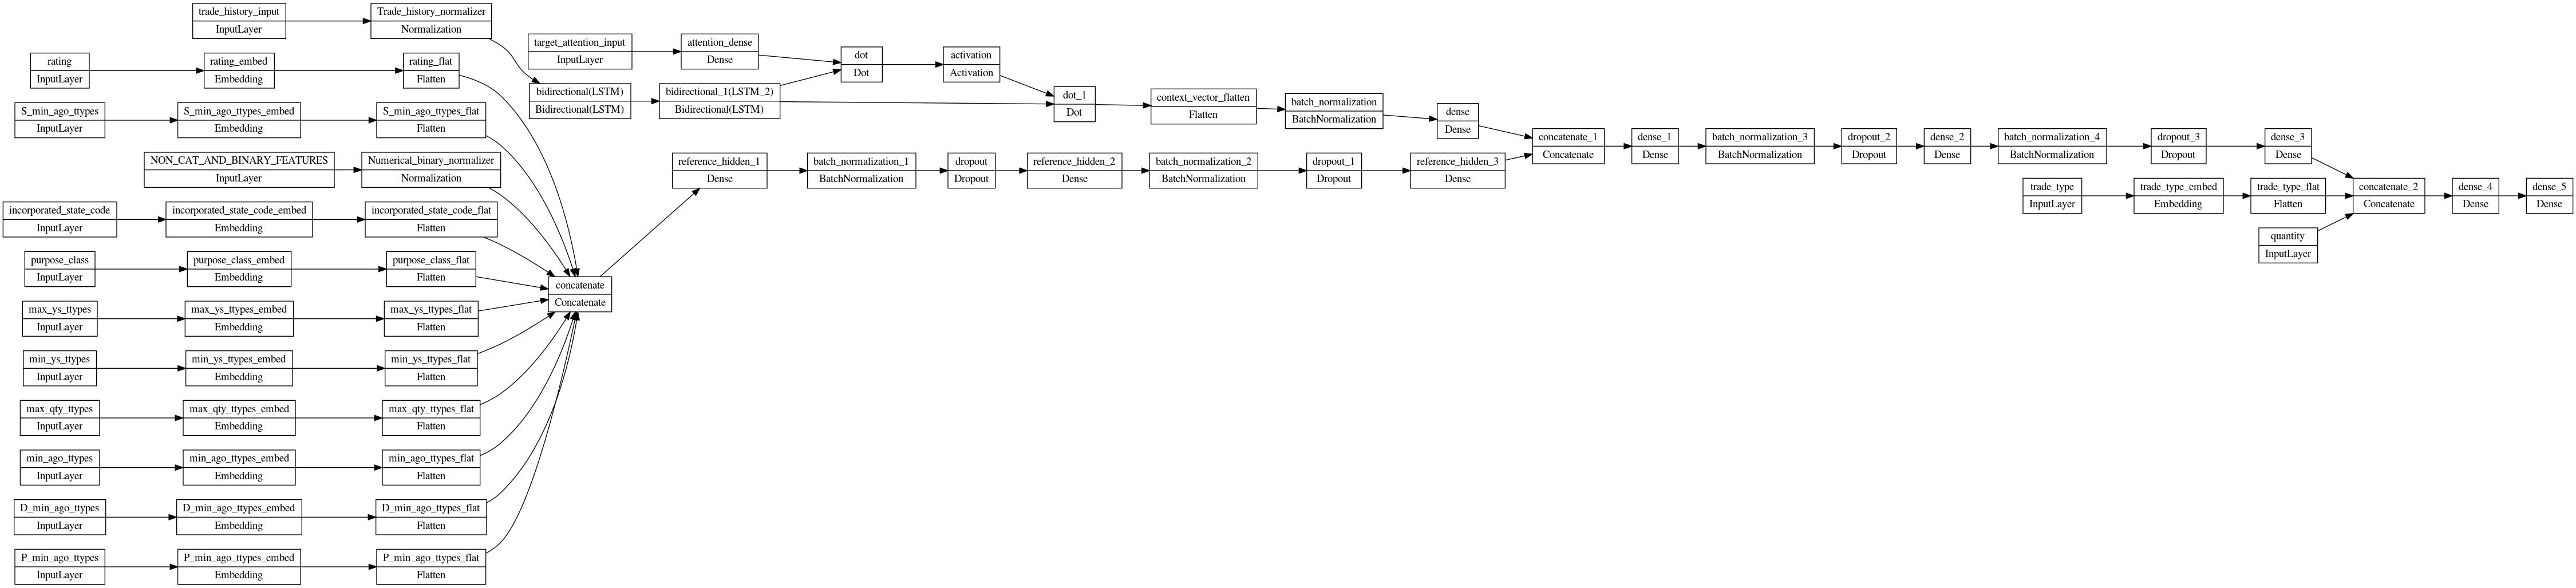

In [53]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [54]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [55]:
fit_callbacks = [
    #WandbCallback(save_model=False),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    time_callback
]

In [56]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.MeanAbsoluteError(),)
              #loss=keras.losses.MeanAbsoluteError())

In [57]:
%%time 
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.1, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8)

Epoch 1/100


2023-11-01 17:04:56.688560: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-01 17:05:01.472162: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


804/805 [============================>.] - ETA: 0s - loss: 47.8436

2023-11-01 17:05:58.302045: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14488961024 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


805/805 [==============================] - 70s 72ms/step - loss: 47.8381 - val_loss: 48.8993
Epoch 2/100
805/805 [==============================] - 59s 73ms/step - loss: 28.3631 - val_loss: 20.3182
Epoch 3/100
805/805 [==============================] - 59s 73ms/step - loss: 14.7092 - val_loss: 13.7752
Epoch 4/100
805/805 [==============================] - 59s 73ms/step - loss: 13.7593 - val_loss: 13.3639
Epoch 5/100
805/805 [==============================] - 59s 73ms/step - loss: 13.4443 - val_loss: 13.2342
Epoch 6/100
805/805 [==============================] - 59s 73ms/step - loss: 13.2762 - val_loss: 13.1130
Epoch 7/100
805/805 [==============================] - 59s 73ms/step - loss: 13.1580 - val_loss: 13.0374
Epoch 8/100
805/805 [==============================] - 59s 73ms/step - loss: 13.0652 - val_loss: 13.0096
Epoch 9/100
805/805 [==============================] - 59s 73ms/step - loss: 12.9801 - val_loss: 12.9801
Epoch 10/100
805/805 [==============================] - 59s 73ms/st

#### Plotting train vs validation loss

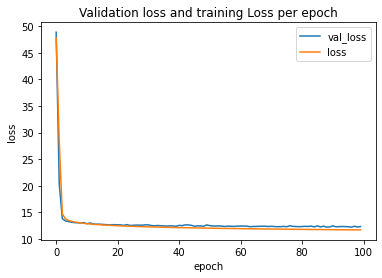

In [58]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Saving the model

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
print(f"file time stamp : {file_timestamp}")

print("Saving encoders and uploading encoders")
with open(f"encoders_new_architecture.pkl",'wb') as file:
    pickle.dump(encoders,file)    
upload_data(storage_client, 'ahmad_data', f"encoders_new_architecture.pkl")

print("Saving and uploading model")
model.save(f"saved_model_new_architecture_{file_timestamp}")
import shutil
shutil.make_archive(f"model_new_architecture_no_batch_norm", 'zip', f"saved_model_new_architecture_{file_timestamp}")
upload_data(storage_client, 'ahmad_data', f"model_new_architecture_no_batch_norm.zip")

file time stamp : 2023-11-01-21-55
Saving encoders and uploading encoders
File encoders_new_architecture.pkl uploaded to ahmad_data.
Saving and uploading model


2023-11-01 21:55:42.271782: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


#### Gigaflops for one epoch of training

In [ ]:
avg_time = np.mean(time_callback.times)

In [ ]:
n = len(x_train[0])
p = model.count_params()
avg_time = np.mean(time_callback.times)
gflops = ((n*p*2*3)/avg_time)/10**9

print(gflops)

### Test accuracy on the entire test set

In [ ]:
test_dataframe['predicted_ys'] = model.predict(x_test, batch_size=BATCH_SIZE) 
test_dataframe['predicted_ytw'] = test_dataframe['new_ficc_ycl'] + test_dataframe['predicted_ys']

In [179]:
test_dataframe['absolute_delta'] = np.abs(test_dataframe.new_ys - test_dataframe.predicted_ys)

#### Test loss: 9.869

In [180]:
print(f"Test loss: {round(np.mean(np.abs(test_dataframe.new_ys - test_dataframe.predicted_ys)), 3)}")

Test loss: 10.066


In [181]:
print(f"YTW loss: {round(np.mean(np.abs(test_dataframe['yield'] - test_dataframe.predicted_ytw)), 3)}")

YTW loss: 10.066


In [182]:
print(f"MAD yield spread model: {round(np.median(np.abs(test_dataframe.new_ys - test_dataframe.predicted_ys)), 3)}")

MAD yield spread model: 5.603


#### Accuracy on a daily basis for dealer dealer trades

In [70]:
for d in [d for d in pd.date_range(start="08/01/2023",end="08/31/2023",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test, batch_size=BATCH_SIZE)
    error = next_day.new_ys - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{np.round(MAE,3)}" )

Date :2023-08-01 MAE:9.866
Date :2023-08-02 MAE:9.875
Date :2023-08-03 MAE:10.308
Date :2023-08-04 MAE:10.044
Date :2023-08-07 MAE:10.041
Date :2023-08-08 MAE:9.752
Date :2023-08-09 MAE:9.251
Date :2023-08-10 MAE:9.46
Date :2023-08-11 MAE:9.446
Date :2023-08-14 MAE:10.112
Date :2023-08-15 MAE:9.367
Date :2023-08-16 MAE:9.226
Date :2023-08-17 MAE:9.948
Date :2023-08-21 MAE:11.212
Date :2023-08-22 MAE:10.621
Date :2023-08-23 MAE:10.292
Date :2023-08-24 MAE:9.879
Date :2023-08-25 MAE:9.708
Date :2023-08-28 MAE:9.832
Date :2023-08-29 MAE:9.828
Date :2023-08-30 MAE:9.465
Date :2023-08-31 MAE:9.483


### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

In [71]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]# & (test_dataframe.coupon == 4)]

In [72]:
len(true_mid)

11751

In [73]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.new_ys

CPU times: user 90.2 ms, sys: 0 ns, total: 90.2 ms
Wall time: 89.3 ms


In [74]:
round(np.mean(np.abs(true_mid.new_ys - true_mid.predicted_ys)), 3)

5.931

In [75]:
%%time
mae = model.evaluate(x_true_mid, y_true_mid, verbose=1, batch_size = BATCH_SIZE)
print(f"Test MAE: {round(mae, 3)}")
# wandb.log({"Dealer Dealer true mid Test MAE": mae})

12/12 [==============================] - 0s 7ms/step - loss: 5.9314
Test MAE: 5.931
CPU times: user 197 ms, sys: 39.5 ms, total: 237 ms
Wall time: 183 ms


### Plotting new ys vs predicted ys

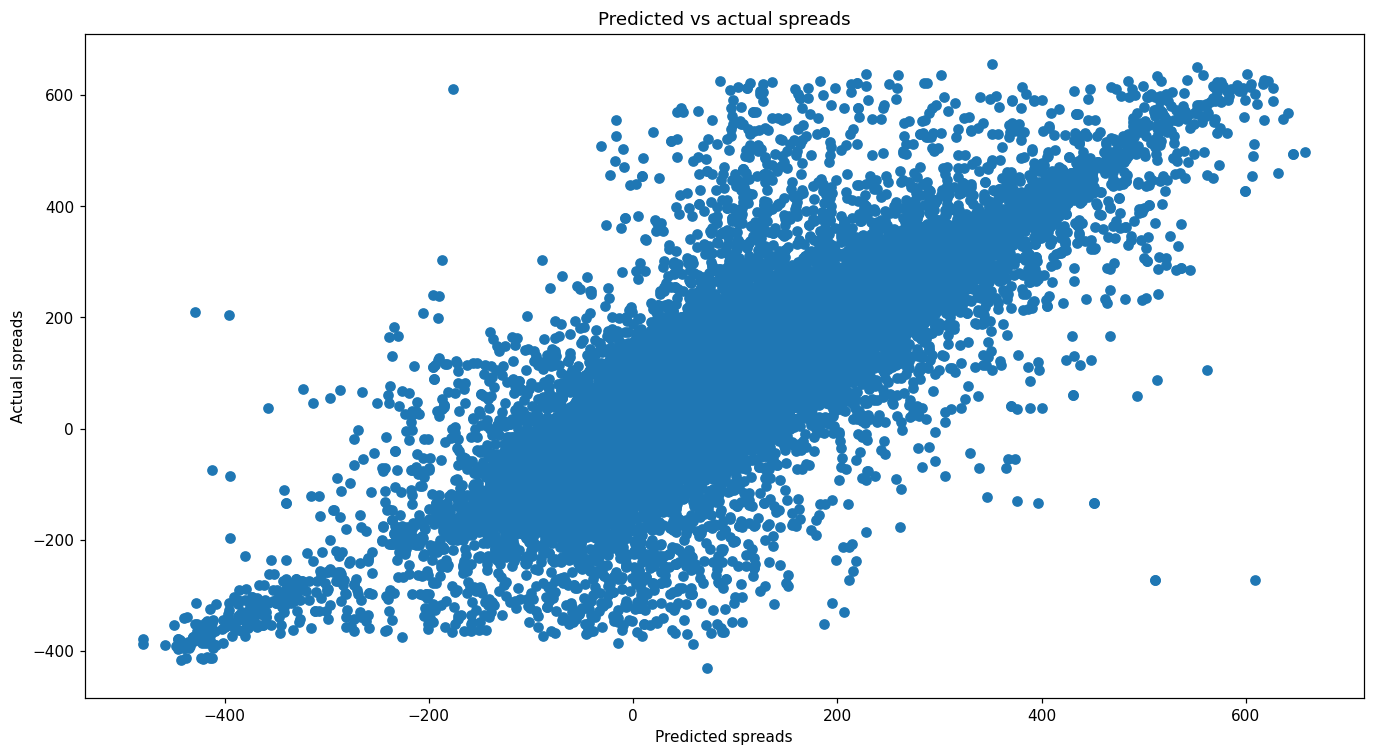

In [76]:
plt.figure(figsize=(15, 8), dpi=110)
plt.xlabel('Predicted spreads')
plt.ylabel('Actual spreads')
plt.title('Predicted vs actual spreads')
plt.scatter(test_dataframe.predicted_ys, test_dataframe.new_ys)

In [71]:
x_test[-2][0]

2.0

In [69]:
model.inputs

[<KerasTensor: shape=(None, 5, 6) dtype=float32 (created by layer 'trade_history_input')>,
 <KerasTensor: shape=(None, 1, 3) dtype=float32 (created by layer 'target_attention_input')>,
 <KerasTensor: shape=(None, 47) dtype=float32 (created by layer 'NON_CAT_AND_BINARY_FEATURES')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'rating')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'incorporated_state_code')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'purpose_class')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'max_ys_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'min_ys_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'max_qty_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'min_ago_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'D_min_ago_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created 

In [65]:
upload_data(storage_client, 'ahmad_data', f"encoders_new_architecture.pkl")

File encoders_new_architecture.pkl uploaded to ahmad_data.


In [71]:
encoders['max_qty_ttypes'].classes_

array(['DD', 'DP', 'DS', 'PD', 'PP', 'PS', 'SD', 'SP', 'SS'], dtype=object)

In [74]:
encoders['max_qty_ttypes'].transform(['DS'])

array([2])